# Import Libraries

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from helpers import parse_variables, simulate_cc_status
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import t
import importlib.util
import warnings
import random

In [29]:
try:
    print(effect_type)
except Exception as e:
    effect_type = "mono"
    print(e)

try:
    print(mafrange)
except Exception as e:
    mafrange = "rare"
    print(e)

try:
    print(effect_size)
except Exception as e:
    effect_size = 1
    print(e)

mono
rare
1


In [30]:
def lin_reg(y, x):
    # Reshape x to have a single feature
    X = x.reshape(-1, 1)
    
    # Fit the linear regression model"
    model = LinearRegression()
    model.fit(X, y)
    
    # Extract coefficients
    beta_hat = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate residuals
    y_hat = model.predict(X)
    residuals = y - y_hat
    
    # Degrees of freedom
    n = len(y)
    k = 1  # Number of features
    df_resid = n - k
    
    # Residual standard error
    s_e = np.sqrt(np.sum(residuals**2) / df_resid)
    
    # Calculate standard error of coefficients
    X_mean = np.mean(X)
    se_beta = s_e / np.sqrt(np.sum((X - X_mean)**2))
    
    # Calculate t-values
    t_values = beta_hat / se_beta
    
    # Calculate p-values
    p_values = (1 - t.cdf(np.abs(t_values), df_resid)) * 2
    
    # Return results
    return intercept, beta_hat, se_beta, t_values, p_values

In [31]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_individuals = c*k*k

In [32]:
complete = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_complete_genotypes_AF_0_0.5.pkl")
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [33]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2

In [34]:
number_of_snps = complete.shape[1]
number_of_snps

863

# Effect based on AF

In [35]:
def multi(arr, effectsize):
    return [1 * (num + 0.001) * effectsize for num in arr]

def divi(arr, effectsize):
    return [(1 / (num + 0.5)) * effectsize for num in arr]

In [36]:
effectsize = effect_size
numbers_af = [float(col.split('_AF_')[1]) for col in common.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in common.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'SNP': snp_names, 'Beta': beta_values}
beta_common = pd.DataFrame(data)
beta_common['maf'] = "common"

numbers_af = [float(col.split('_AF_')[1]) for col in rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'SNP': snp_names, 'Beta': beta_values}
beta_rare = pd.DataFrame(data)
beta_rare['maf'] = "rare"

numbers_af = [float(col.split('_AF_')[1]) for col in very_rare.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in very_rare.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'SNP': snp_names, 'Beta': beta_values}
beta_very_rare = pd.DataFrame(data)
beta_very_rare['maf'] = "very rare"

betas = pd.concat([beta_common, beta_rare, beta_very_rare], ignore_index=True)

In [37]:
betas

,SNP,Beta,maf
0,C0,1.255611,common
1,C1,1.391111,common
2,C2,1.403016,common
3,C3,1.357220,common
4,C4,1.393680,common
...,...,...,...
858,VR280,1.937703,very rare
859,VR281,1.957713,very rare
860,VR282,1.968504,very rare
861,VR283,1.958768,very rare


In [38]:
complete = pd.concat([common, rare, very_rare], axis=1)

In [39]:
arr1 = list(complete.columns)
arr2 = list(betas['SNP'])

In [40]:
new_arr = [arr2[i] + '_AF_' + item.split('_AF_')[1] for i, item in enumerate(arr1)]

In [41]:
complete.columns = new_arr

In [42]:
complete

,C0_AF_0.296425,C1_AF_0.21885,C2_AF_0.21275,C3_AF_0.2368,C4_AF_0.217525,C5_AF_0.20005,C6_AF_0.26035,C7_AF_0.3068,C8_AF_0.222275,C9_AF_0.296525,...,VR275_AF_0.0094,VR276_AF_0.00495,VR277_AF_0.0182,VR278_AF_0.008725,VR279_AF_0.003725,VR280_AF_0.016075,VR281_AF_0.0108,VR282_AF_0.008,VR283_AF_0.010525,VR284_AF_0.00345
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [43]:
mu = 0
env = 0
snpXsnp = 0

In [44]:
betas

,SNP,Beta,maf
0,C0,1.255611,common
1,C1,1.391111,common
2,C2,1.403016,common
3,C3,1.357220,common
4,C4,1.393680,common
...,...,...,...
858,VR280,1.937703,very rare
859,VR281,1.957713,very rare
860,VR282,1.968504,very rare
861,VR283,1.958768,very rare


In [45]:
Ps_expected = []
snps_expected = []
betas_calculated = []
AFs = []
pheno_mono = []
for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    # Set all other Beta values to zero except the one specified by index_to_keep
    result = betas.loc[betas['SNP'] == snp.split("_AF_")[0]]
    beta_expected = result['Beta'].values[0]
    geno = np.array(complete[snp])
    pheno = geno*beta_expected
    pheno_mono.append(pheno)
    try:
        intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        snps_expected.append(snp.split("_AF_")[0])
        Ps_expected.append(p_values)
        AFs.append(snp.split("_AF_")[1])
        betas_calculated.append(beta_hat)
    except Exception as e:
        print(e)

/tmp/ipykernel_8448/3045608009.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  t_values = beta_hat / se_beta


In [46]:
data = {'SNP': snps_expected, 'Beta_calculated': betas_calculated, "AF": AFs}
betas_calculated = pd.DataFrame(data)

In [47]:
betas.reset_index(inplace=True)

In [48]:
merged_df = pd.merge(betas, betas_calculated, on='SNP', how='inner')
merged_df

,index,SNP,Beta,maf,Beta_calculated,AF
0,0,C0,1.255611,common,1.255611,0.296425
1,1,C1,1.391111,common,1.391111,0.21885
2,2,C2,1.403016,common,1.403016,0.21275
3,3,C3,1.357220,common,1.357220,0.2368
4,4,C4,1.393680,common,1.393680,0.217525
...,...,...,...,...,...,...
858,858,VR280,1.937703,very rare,1.937703,0.016075
859,859,VR281,1.957713,very rare,1.957713,0.0108
860,860,VR282,1.968504,very rare,1.968504,0.008
861,861,VR283,1.958768,very rare,1.958768,0.010525


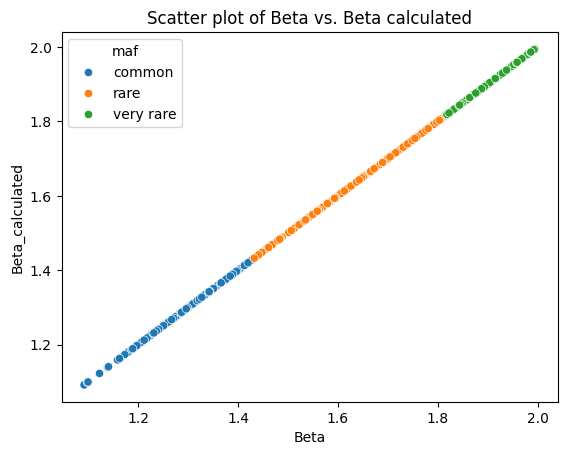

In [49]:
sns.scatterplot(x='Beta', y='Beta_calculated', data=merged_df, hue="maf")
plt.xlabel('Beta')
plt.ylabel('Beta_calculated')
plt.title('Scatter plot of Beta vs. Beta calculated')
plt.show()

# Polygenic model

In [50]:
pheno_poly = []
proportion_poly = 0.05
Ps_expected = []
snps_expected = []
betas_calculated = []
AFs = []
all_snps = list(complete.columns)
poly_friends_quantity = int(np.round(len(all_snps)*proportion_poly))
for snp in all_snps:
    index_to_keep = snp.split("_AF_")[0]
    # Set all other Beta values to zero except the one specified by index_to_keep
    result = betas.loc[betas['SNP'] == snp.split("_AF_")[0]]
    beta_expected = result['Beta'].values[0]
    geno = np.array(complete[snp])
    
    pheno = geno*beta_expected
    poly_snps = random.sample(all_snps, poly_friends_quantity)
    for poly_snp in poly_snps:
        result = betas.loc[betas['SNP'] == poly_snp.split("_AF_")[0]]
        beta_expected = (result['Beta'].values[0])/10
        poly_geno = np.array(complete[poly_snp])
        pheno += poly_geno*beta_expected
    pheno_poly.append(pheno)
    try:
        intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        snps_expected.append(snp.split("_AF_")[0])
        Ps_expected.append(p_values)
        AFs.append(snp.split("_AF_")[1])
        betas_calculated.append(beta_hat)
    except Exception as e:
        print(e)

In [51]:
data = {'SNP': snps_expected, 'Beta_calculated': betas_calculated, "AF": AFs}
betas_calculated = pd.DataFrame(data)

In [52]:
merged_df = pd.merge(betas, betas_calculated, on='SNP', how='inner')
merged_df

,index,SNP,Beta,maf,Beta_calculated,AF
0,0,C0,1.255611,common,1.512685,0.296425
1,1,C1,1.391111,common,1.424287,0.21885
2,2,C2,1.403016,common,1.536920,0.21275
3,3,C3,1.357220,common,1.373910,0.2368
4,4,C4,1.393680,common,1.325334,0.217525
...,...,...,...,...,...,...
858,858,VR280,1.937703,very rare,2.035721,0.016075
859,859,VR281,1.957713,very rare,1.921582,0.0108
860,860,VR282,1.968504,very rare,1.964965,0.008
861,861,VR283,1.958768,very rare,1.809272,0.010525


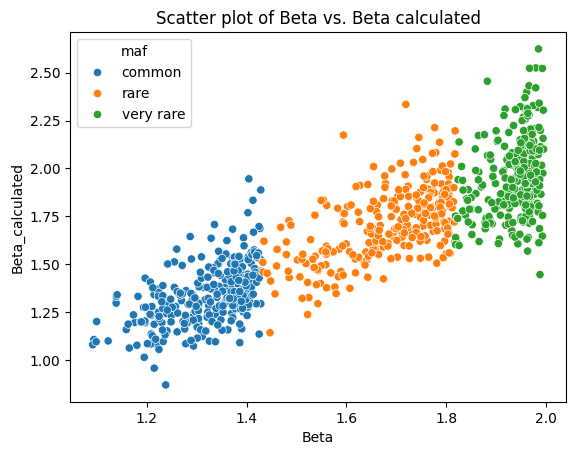

In [53]:
sns.scatterplot(x='Beta', y='Beta_calculated', data=merged_df, hue="maf")
plt.xlabel('Beta')
plt.ylabel('Beta_calculated')
plt.title('Scatter plot of Beta vs. Beta calculated')
plt.show()

In [54]:
#complete.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_complete_genotypes_AF_0_0.5.pkl")
#very_rare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
#rare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
#common.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [55]:
os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/snp_effect/",exist_ok=True)

In [56]:
pheno_mono = pd.DataFrame(list(map(list, zip(*pheno_mono))), columns=all_snps)
pheno_poly = pd.DataFrame(list(map(list, zip(*pheno_poly))), columns=all_snps)

In [58]:
pheno_mono.to_pickle(f"data//G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/snp_effect/mono_AF_0_0.5.pkl")
pheno_poly.to_pickle(f"data//G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/snp_effect/poly_AF_0_0.5.pkl")